In [17]:
# importing functions for analysis
# I find I have to run this cell twice to get nice, large plots
from functions import *
from sim_functions import *

# sometimes just need to run with the below line uncommented
plt.rcParams['figure.dpi'] = 200

# Simulations with PENTrack

In this notebook, simulation results from PENTrack are used in conjection with the experimental analysis in order to determine various material parameters.

## Questions

- what is an apporpriate number for simulated particles. Right now I'm achievuing only 10000 simulated particles (due to time-out issues) and less than 2000 are making it to the detector. Contrast that with experiment, where ~100000 are being detected in an equivalent run. 
- I should be able to just judge based on whatever error bar I get from each method, is the error on the fit parameter p1 correct? Is the built-in 'expo' function what you would use for this fit? If I can demonstrate a lack of agreement, or a lack of sensitivity to changes in drp, from just 10000 simulated particles, then we can move on right? 
- What do we move on to? If we're not able to budge this time constant by changing drp, then should I start changing imaginary fermi? This I would use to match just to pre-storage time, right? 
- Review my materials.in to make sure I'm setting things appropriately (where I 0'ed the other parameters in order to change drp)

## Direction
- Generate a function that takes as input the pre-storage time, and the configuration (to begin with, only TRIUMF-style), then it produces the drp1 and drp10 exponential fits (as shown below) using ROOT. For this it requires only the out.ROOT files, named strategically.
- Put the time constant analysis notebook in here, where it belongs.

# Diffuse Reflection Probability Analysis

We assume that the tail of the main detection peak is the most sensitive parameter to the diffuse reflection probability of the materials. 

## Experimental Data

The example below shows a fit of the experimental data

fit will begin at 25.6 s
fit will end at 45.6 s
[[Model]]
    Model(expo)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 211
    # data points      = 200
    # variables        = 2
    chi-square         = 491.868149
    reduced chi-square = 2.48418257
    Akaike info crit   = 183.978665
    Bayesian info crit = 190.575299
[[Variables]]
    p0:  18.1961353 +/- 0.07033300 (0.39%) (init = 80)
    p1:  2.50649829 +/- 0.01564219 (0.62%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(p0, p1) = -0.997



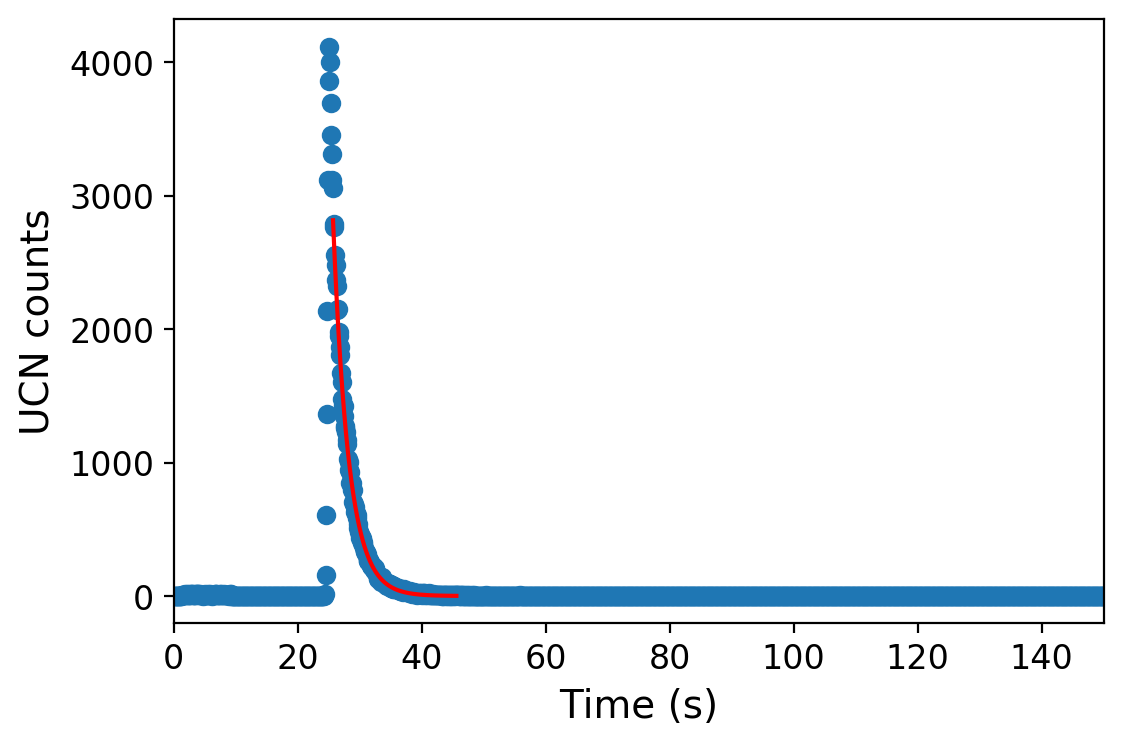

In [104]:
# load data from an example run 
filename = 'T081217_0034.tof'
arr = np.loadtxt("../data_ucn/main_detector/8/" + filename, usecols = (0,1));

# exponential function, same as ROOT's built-in 'expo'
def expo(x, p0, p1):
    return np.exp(p0 - 1/(p1) * x)

# times in seconds, specific to each run
irradiate_time = 8
fill_time = 8.6
pre_storage_time = 5
buffer_time = 4

# time length over which the fit will span
fit_span_time = 20

# compute the fit start and end times
fit_start_time = irradiate_time + fill_time + pre_storage_time + buffer_time
fit_end_time   = fit_start_time + fit_span_time

print('fit will begin at {} s'.format(fit_start_time))
print('fit will end at {} s'.format(fit_end_time))

# the experimental data is binned into 0.1s bins, and lmfit requires
# that we pass it the array we want fitted. We need to multiply these
# times to get the right indices for slicing the arrays
fit_start_index = int(fit_start_time * 10)
fit_end_index   = int(fit_end_time * 10)

# we get the arrays of counts and time, multiplying the values of t by 
# 0.1 to get it in seconds.
c = arr[fit_start_index:fit_end_index, 1]
t = arr[fit_start_index:fit_end_index,0] * 0.1

# construct weights, we deal with entries = 0 by giving them 0 weight
weights = np.zeros(np.shape(c))
for i in range(0,np.shape(c)[0]):
    if (c[i] != 0):
        weights[i] = 1 / np.sqrt(c[i])
    else:
        weights[i] = 0
        
gmodel = Model(expo)
result = gmodel.fit(c, x=t, p0=80, p1=3, weights = weights)

print(result.fit_report())
plt.plot(arr[:,0] * 0.1, arr[:,1], 'o')
plt.plot(t, result.best_fit, 'r-')
plt.xlim([0,150])
plt.ylabel('UCN counts', fontsize = 14)
plt.xlabel('Time (s)', fontsize = 14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('../img/rough_tail_fit.pdf')
plt.show()

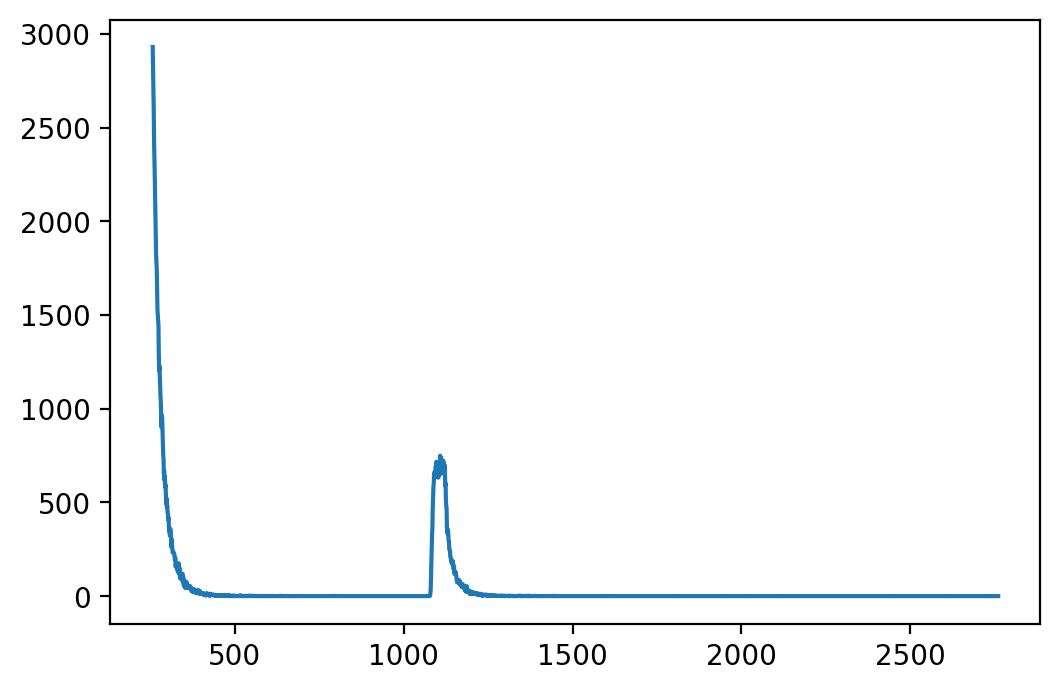

In [53]:
plt.plot(t, counts)

In [50]:
np.shape(arr)

(4000, 2)

Next, this is performed iteratively on the data from each run in both the TRIUMF-style normalization confirguration, and the JP-style normalization configuration. 

(NOMI,s005): 2.6458+/-0.0025
(NOMI,s020): 2.8132+/-0.0031
(NOMI,s100): 3.194+/-0.006
(DISK,s005): 2.885+/-0.008
(DISK,s020): 3.061+/-0.009
(DISK,s100): 3.378+/-0.019


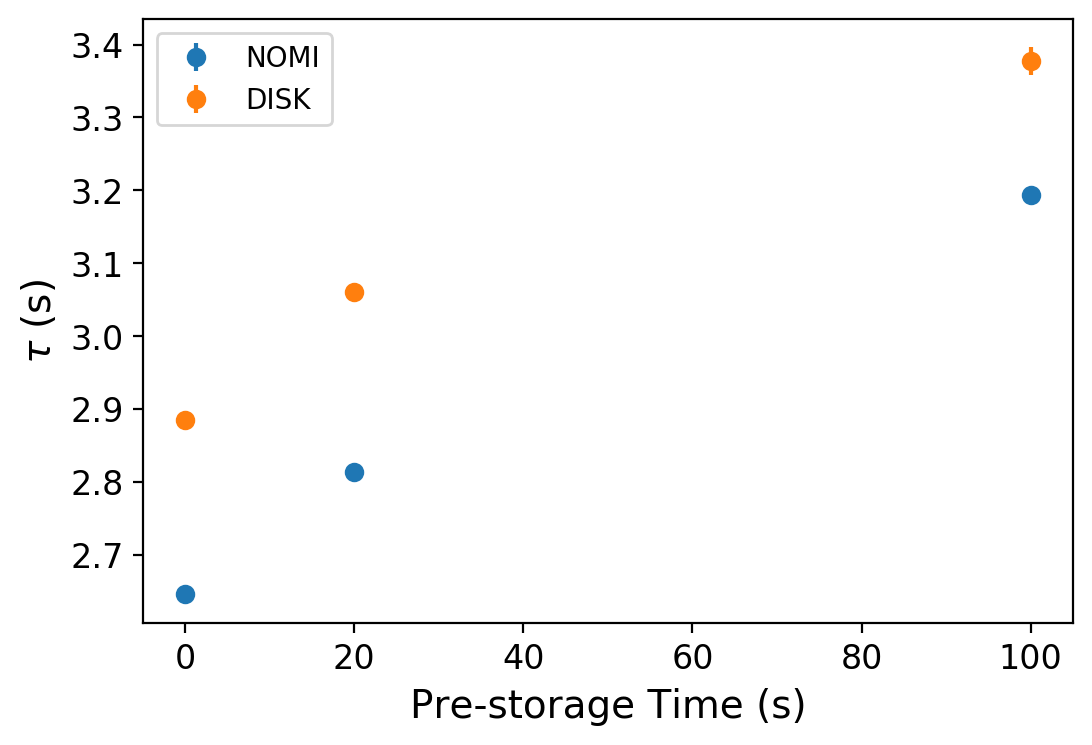

In [105]:
# dictionary to hold time constant values
tau_dict   = {} 

# dictionary to hold p1 values
exp_p1_dict = {}

fig, ax = plt.subplots()
ax_c = plt.gca()

# exponential function
def expo(x, p0, p1):
    return np.exp(p0 - 1 / (p1) * x)

# times relevant for fitting window selection
irradiate_time = 8
fill_time = 8.6
buffer_time = 4

# time length over which the fit will span
fit_span_time = 50

for config in ['NOMI', 'DISK']:
    
    color = next(ax_c._get_lines.prop_cycler)['color']
    
    for run_type in ['s005', 's020', 's100']:
        
        # we'll save tau and error
        tau_dict[config, run_type] = np.empty((0,3), float)

        for filename in os.listdir('../data_ucn/main_detector_sorted'):

            # Only the files matching our desired configuration and run 
            # type are selected. The '.tof' condition is just so we 
            # don't perform the analysis twice per run (since it would
            # otherwise match to the .tof and the .txt files)
            if ((config in filename) and (run_type in filename) and 
            ('.tof' in filename)):

                # The data is retrieved from the .tof file
                arr = np.loadtxt('../data_ucn/main_detector_sorted/' + 
                                        filename[0:22] + '.tof',
                                        usecols = (0,1))

                # times in seconds, specific to each run
                pre_storage_time = float(run_type[1:4])

                # compute the fit start and end times
                fit_start_time = irradiate_time + fill_time + pre_storage_time + buffer_time
                fit_end_time   = fit_start_time + fit_span_time

                # the experimental data is binned into 0.1s bins, and lmfit requires
                # that we pass it the array we want fitted. We need to multiply these
                # times to get the right indices for slicing the arrays
                fit_start_index = int(fit_start_time * 10)
                fit_end_index   = int(fit_end_time * 10)

                # we get the arrays of counts and time, multiplying the values of t by 
                # 0.1 to get it in seconds.
                c = arr[fit_start_index:fit_end_index, 1]
                t = arr[fit_start_index:fit_end_index,0] * 0.1

                # construct weights, we deal with entries = 0 by giving them 0 weight
                weights = np.zeros(np.shape(c))
                for i in range(0,np.shape(c)[0]):
                    if (c[i] != 0):
                        weights[i] = 1 / np.sqrt(c[i])
                    else:
                        weights[i] = 0

                gmodel = Model(expo)
                result = gmodel.fit(c, x=t, p0=80, p1=3, weights = weights)
              
                tau_dict[config, run_type] = np.append(
                    tau_dict[config, run_type], 
                    [[result.params['p1'].value, result.params['p1'].stderr, result.redchi]],
                    axis=0)
        
        # finished with given [config, run_type]
        # generate uncertainty array of data set, calculate mean, add to dict
        arr = tau_dict[config, run_type]
        uarr = unumpy.umatrix(arr[:,0], arr[:,1])
        ave_tau = uarr.mean(1)[0,0]
        exp_p1_dict[config, run_type] = ave_tau
        
        # average the redchi of all the fits, save to dict
        exp_p1_dict[config, run_type, 'redchi'] = arr[:,2].mean()

        storage_time = int(run_type[1:-1])

        # add mean value to plot
#         JP-style
        if (config == 'DISK'):

            ax.errorbar(storage_time * 10, ave_tau.nominal_value, yerr = ave_tau.std_dev, 
                          fmt = 'o', label = config, color = color)

#         TRIUMF-style
        else:
            ax.errorbar(storage_time * 10, ave_tau.nominal_value, yerr = ave_tau.std_dev, 
                          fmt = 'o', label = config, color = color)
            
        print('(' + config + ',' + run_type + '): {}'.format(ave_tau))
                               
# presentation stuff
ax.set_ylabel(r'$\tau$ (s)', fontsize = 14);
ax.set_xlabel('Pre-storage Time (s)', fontsize = 14)
ax.legend();
ax.tick_params(axis='both', which='major', labelsize=12)
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys());   
fig.savefig('../img/all_norm_tail_fits.pdf')

## Simulated Data

In the example below, simulation data produced with PENTrack are analysed in an analogous way to as seen above.

../data_sim/NOMI_s100_dp01.root
#####
NOMI, s100, dp = 1
#####

fitting range = [120.6, 140.6]

 FCN=116.07 FROM MIGRAD    STATUS=CONVERGED     539 CALLS         540 TOTAL
                     EDM=2.00403e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.02511e+00   2.28746e+00   5.33902e-04  -1.97113e-03
   2  p1           1.83964e+01   6.00366e+00   1.40040e-03  -7.52443e-04
                               ERR DEF= 0.5


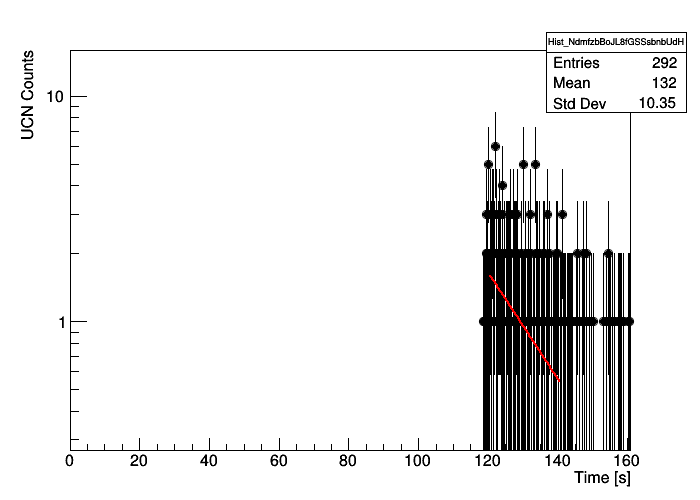

In [106]:
canvas, slope, redchi = sim_tau('NOMI', 's100', 1)

Next we perform this iteratively for different pre-storage times and diffuse reflection probabilities.

../data_sim/NOMI_s005_dp01.root
#####
NOMI, s005, dp = 1
#####

fitting range = [25.6, 45.6]

../data_sim/NOMI_s005_dp10.root
#####
NOMI, s005, dp = 10
#####

fitting range = [25.6, 45.6]

../data_sim/NOMI_s020_dp01.root
#####
NOMI, s020, dp = 1
#####

fitting range = [40.6, 60.6]

../data_sim/NOMI_s020_dp10.root
#####
NOMI, s020, dp = 10
#####

fitting range = [40.6, 60.6]

../data_sim/NOMI_s100_dp01.root
#####
NOMI, s100, dp = 1
#####

fitting range = [120.6, 140.6]

../data_sim/NOMI_s100_dp10.root
#####
NOMI, s100, dp = 10
#####

fitting range = [120.6, 140.6]

 FCN=92.1703 FROM MIGRAD    STATUS=CONVERGED     568 CALLS         569 TOTAL
                     EDM=4.4596e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.19351e+00   1.51814e-01   1.61888e-04  -2.23483e-03
   2  p1           1.11518e+01   5.68791e-01   6.06348e-

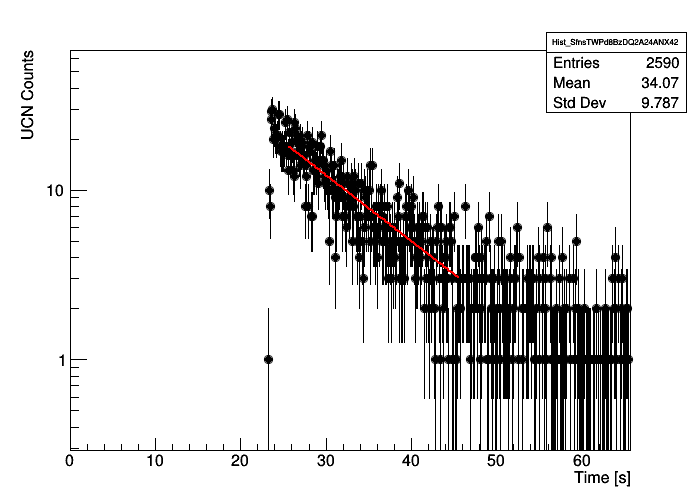

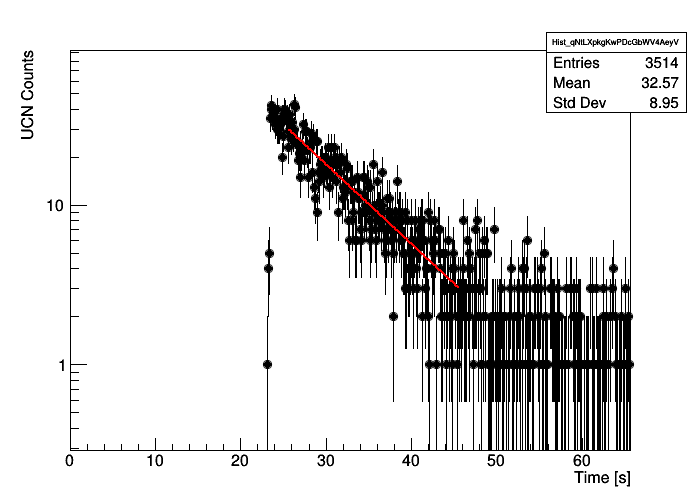

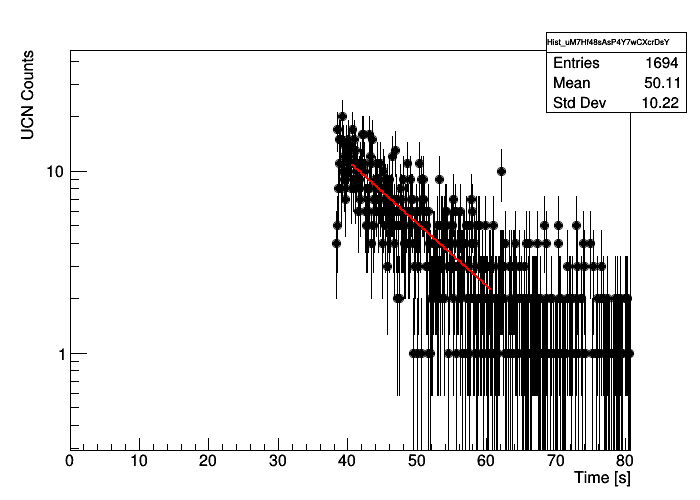

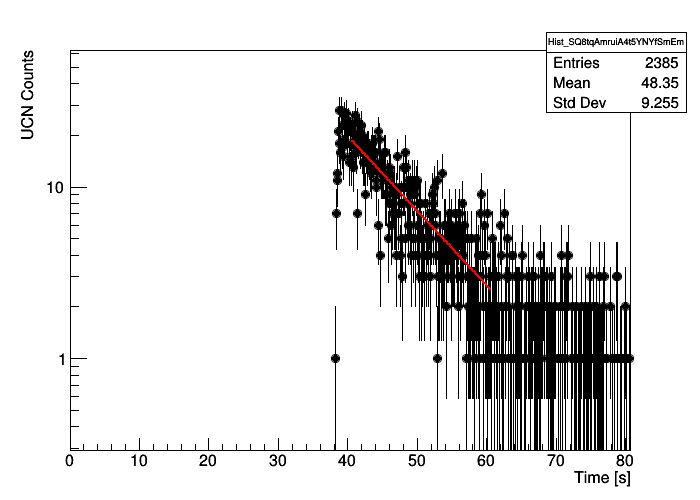

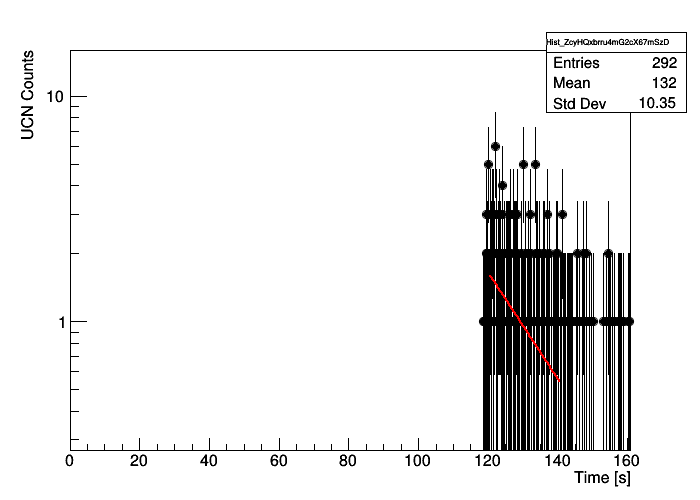

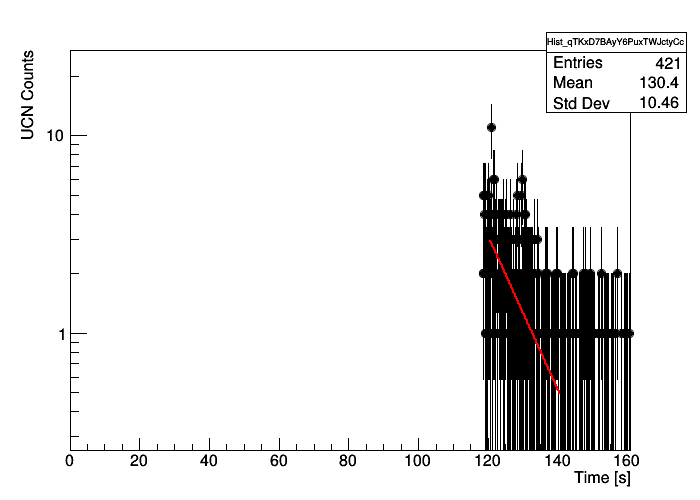

In [107]:
canvas_dict = {}
sim_p1_dict = {}

for config in ['NOMI']:
    
#     for run_type in ['s005']:
    for run_type in ['s005', 's020', 's100']:
        
#         for diffuse_probability in [10]:
        for diffuse_probability in [1, 10]:
            
            canvas, slope, redchi = sim_tau(config, run_type, diffuse_probability)
            
            canvas_dict[config, run_type, str(diffuse_probability)] = canvas
            
            sim_p1_dict[config,run_type,str(diffuse_probability)] = slope
            
            sim_p1_dict[config,run_type,str(diffuse_probability), 'redchi'] = redchi

Experimental Data (NOMI, s005), average redchi = 0.9683533810698157
Simulated Data (NOMI, s005, 1), redchi = 1.1891847724504503
Simulated Data (NOMI, s005, 10), redchi = 1.4875189426809756
Experimental Data (NOMI, s020), average redchi = 0.7026892321173861
Simulated Data (NOMI, s020, 1), redchi = 1.5317216390553867
Simulated Data (NOMI, s020, 10), redchi = 1.468151267797863
Experimental Data (NOMI, s100), average redchi = 0.40762875702411316
Simulated Data (NOMI, s100, 1), redchi = 0.6021549518803999
Simulated Data (NOMI, s100, 10), redchi = 0.8481478759478188


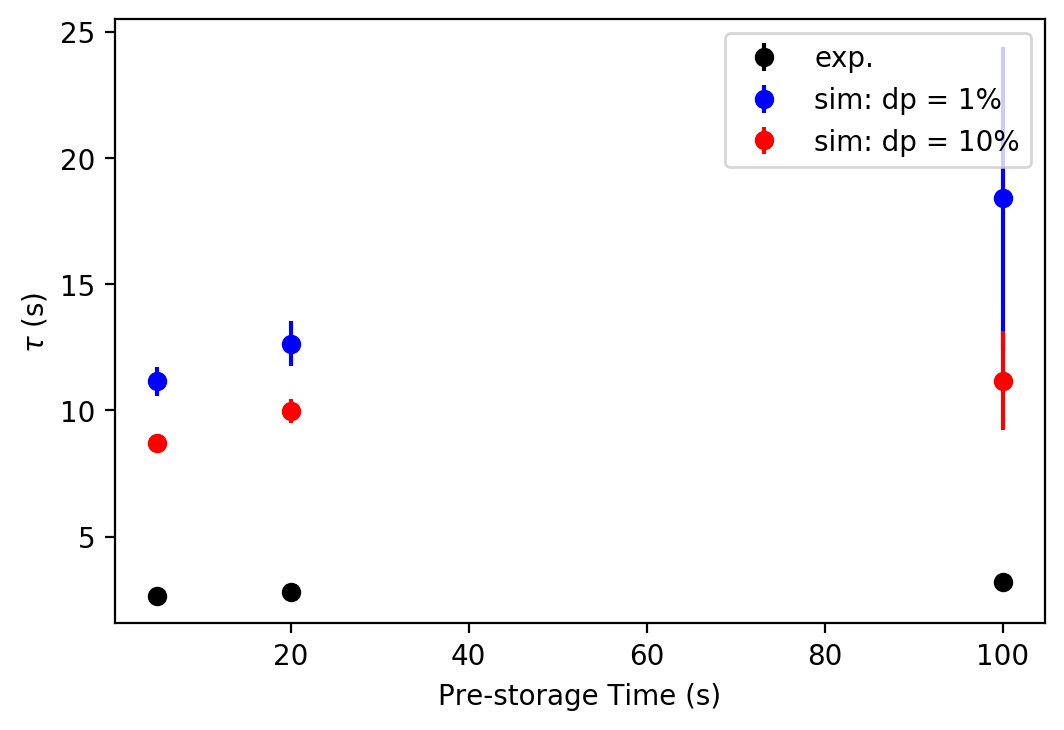

In [109]:
fig, ax = plt.subplots()
ax1 = plt.gca()

color_dict = {}
color_dict['1'] = 'b'
color_dict['10'] = 'r'

for config in ['NOMI']:
# for config in ['NOMI', 'DISK']:
    
#     for run_type in ['s005']:
    for run_type in ['s005', 's020', 's100']:
    
        exp_slope = exp_p1_dict[config, run_type]
        
        ax.errorbar(float(run_type[1:4]), exp_slope.nominal_value, yerr = exp_slope.std_dev,
                       label = 'exp.', fmt = 'o', color = 'k')
        
        print('Experimental Data (' + config + ', ' + run_type + '), average redchi = {}'.format(
        exp_p1_dict[config, run_type, 'redchi']))
        
        for diffuse_probability in [1, 10]:
    
#             if (config == 'NOMI' and run_type == 's005' and diffuse_probability == 10):
            
            slope = sim_p1_dict[config, run_type, str(diffuse_probability)]

            color = color_dict[str(diffuse_probability)]
            
            ax.errorbar(float(run_type[1:4]), slope.nominal_value, yerr = slope.std_dev,
                       label = 'sim: dp = {}%'.format(diffuse_probability), fmt = 'o', color = color)
            
            print('Simulated Data (' + config + ', ' + run_type + ', ' + 
                  str(diffuse_probability) + '), redchi = {}'.format(
            sim_p1_dict[config, run_type, str(diffuse_probability), 'redchi']))
            
                
#             if (config == 'NOMI' and run_type == 's005' and diffuse_probability == 1):
            
#                 slope = sim_p1_dict[config, run_type, str(diffuse_probability)]
                
#                 color = next(ax1._get_lines.prop_cycler)['color']
                
#                 ax.errorbar(float(run_type[1:4]), slope.nominal_value, yerr = slope.std_dev,
#                            label = 'sim: dp = {}%'.format(diffuse_probability), fmt = 'o', color = color)
        
    
ax.set_ylabel(r'$\tau$ (s)')
ax.set_xlabel('Pre-storage Time (s)')
ax.legend();
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys());

## Scratch

- make an iterative function that does all the simulation data at once
- put all the experimental analysis in here
- make a function that takes both data sets and produces publication ready plots for comparison, with full error analysis

In [35]:
str(1).zfill(2)

'01'

In [1]:
diffuse_probability = 1
f = root_open('../data_sim/' + 'NOMI' + '_' + 's100' + 
              '_dp' + str(diffuse_probability).zfill(2) + '.root')

# print data information
print('#####')
print(config + ', ' + run_type + ', dp = {}'.format(diffuse_probability))
print('#####\n')
# get the neutronend tree
end = f.Get('neutronend')

# using rootpy to define the histogram
h1 = Hist(4000, 0, 400)

# a canvas for plotting
canvas = Canvas(width=700, height=500)

# fill a histogram with only the neutrons ending in the detector
for evt in f.neutronend:
   if evt.solidend == 200: h1.Fill(evt.tend)

# set the axis ranges for viewability
#     h1.GetYaxis().SetRangeUser(0, 50)
h1.GetXaxis().SetRangeUser(0, 100)

# logarithmic y scale 
canvas.SetLogy()

# draw histogram to the canvas
h1.Draw("hist")
canvas.Draw()

# fitting
f1 = ROOT.TF1("m1","expo",25,80)
f1.SetParameters(7,-0.2)
fit = h1.Fit(f1, 'SRL')

# get the slope, or inverse tau, parameter
slope = 1

h1.GetXaxis().SetTitle('Time [s]')
h1.GetYaxis().SetTitle('UCN Counts')
h1.Draw()

NameError: name 'root_open' is not defined

In [67]:
print(f1.GetParameter(1))
print(f1.GetParError(1))

-0.09425743849006823
0.0026649604693394207
